# Tarea 4

## Tarea 4.1

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data_processed_final.csv").select_dtypes(include=[np.number])

Antes de utilizar dbscan, es importante escalar los datos. También, esto será útil para aplicar PCA después

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

numeric_cols = df.select_dtypes(include=[np.number])

binary_cols = numeric_cols.columns[numeric_cols.nunique() == 2]

excluded_cols = ["dia_semana_sin", "dia_semana_cos", "rango_horario_sin", "rango_horario_cos"]

cols_to_scale = numeric_cols.columns.difference(binary_cols).difference(excluded_cols)

# Escalar las columnas seleccionadas
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

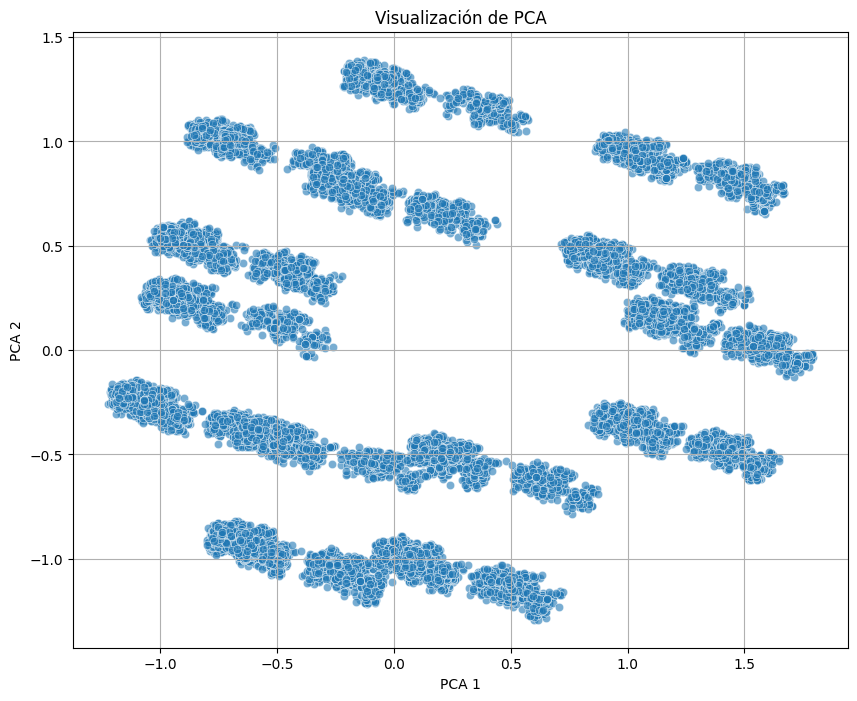

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pca = PCA(n_components=2)

pca_results = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(pca_results, columns=['PCA_1', 'PCA_2'])

# Visualización
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA_1', 
    y='PCA_2', 
    data=df_pca, 
    alpha=0.6
)
plt.title("Visualización de PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [4]:
from sklearn.decomposition import PCA
import pandas as pd

# Ajustar PCA para conservar el 95% de la variabilidad
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

print(f"Componentes seleccionados: {pca.n_components_}")
explained_variance = pca.explained_variance_ratio_.cumsum()
print(f"Varianza explicada acumulada: {explained_variance[-1]:.2f}")

df_pca = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print(df_pca.head())

Componentes seleccionados: 55
Varianza explicada acumulada: 0.95
        PC1       PC2       PC3       PC4       PC5       PC6       PC7   
0 -0.785464 -0.961760 -0.102946  0.986750 -0.472083 -0.417337  0.825529  \
1 -0.655031 -1.010918 -0.201084  0.785156 -0.372919  0.024185 -0.672893   
2 -0.726158 -0.959281 -0.123073  0.872007 -0.408480 -0.280480  1.101468   
3 -0.736615 -0.961710 -0.066156  0.787200 -0.256041 -0.678589  0.366694   
4  1.068194  0.928140  0.537160  0.812430 -0.426321 -0.414639 -0.425172   

        PC8       PC9      PC10  ...      PC46      PC47      PC48      PC49   
0  0.192186  0.542679  0.784201  ...  0.836498  0.338514 -0.139319  0.021671  \
1  0.338327  1.023724  0.498784  ...  0.854410  0.369306 -0.082276 -0.079237   
2 -0.090518  0.707778  0.667934  ...  0.011555 -0.034092  0.085303  0.168743   
3  0.013113  0.300675  0.997417  ... -0.055123 -0.023467  0.036360 -0.079266   
4  0.145101 -0.033045 -0.057178  ... -0.080037 -0.088442  0.015201  0.101869   

   

Algoritmos como dbscan funcionan bastante mal cuando los datos son muy densos y poseen alta dimensionalidad, es por eso que aplicar PCA ayuda a reducir la dimensionalidad conservando un gran porcentaje de variabilidad y facilitando el trabajo al algoritmo.

In [5]:
X = df_pca.to_numpy()

Se puede observar que los puntos no son fácilmente separables y, por tanto, los clusters no están bien definidos. Haciendo que probablemente los índices que se cálculen para evaluar la calidad del cluster posteriormente, no den muy buenos resultados.

## Tarea 4.2

Utilizando el gráfico de distancias al k-ésimo vecino más cercano (donde k=min_samples−1) se puede identificar un valor adecuado de eps para DBSCAN. Ordena estas distancias de menor a mayor y las grafica, formando un "codo" en el gráfico. El punto donde ocurre este codo indica un cambio abrupto en las distancias y suele ser un buen valor para eps, ya que separa regiones densas de ruido.

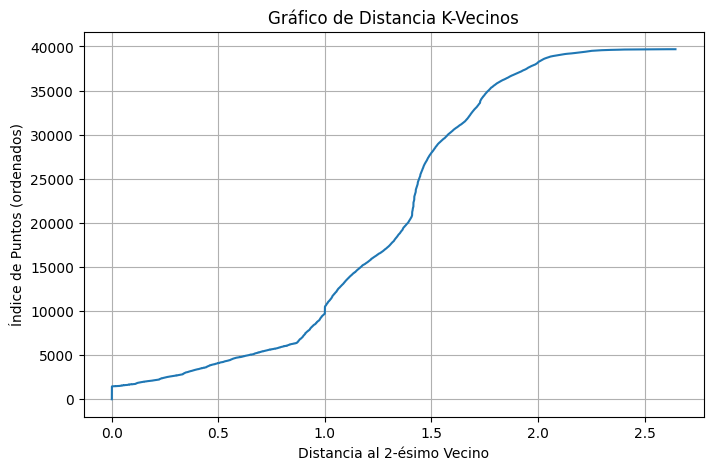

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

k = 2
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Ordenar distancias del k-ésimo vecino más cercano
distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 5))
plt.plot(distances, np.arange(len(distances)))
plt.title("Gráfico de Distancia K-Vecinos")
plt.ylabel("Índice de Puntos (ordenados)")
plt.xlabel(f"Distancia al {k}-ésimo Vecino")
plt.grid(True)
plt.show()


Observando la gráfica se puede apreciar que en el valor 0.8 aproximadamente hay un codo. Ya que es cuando la pendiente comienza a separarse.

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Se prueba como varía la calidad del cluster probando diferentes valores de eps y min_samples. Estos resultados se almacenan en un df de resultados para poder ser analizados posteriormente. Para este apartado se prestará especial atención a los valores que generen los indices con el eps escogido y diferentes min_samples.

In [8]:
# Rango de valores para eps y min_samples
eps_values = np.arange(0.1, 2, 0.1)
min_samples_values = range(2, 18)

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = db.labels_

        if len(set(labels)) > 2:
            silhouette = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            results.append({
                'indice': 'Silhouette', 'valor': silhouette, 'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters, 'n_noise': n_noise
            })
            results.append({
                'indice': 'Calinski-Harabasz', 'valor': calinski_harabasz, 'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters, 'n_noise': n_noise
            })

            print(f"eps: {eps}")
            print(f"min_samples: {min_samples}")
            print("Resultados almacenados para esta combinación.\n\n")

results_df = pd.DataFrame(results)

eps: 0.1
min_samples: 2
Resultados almacenados para esta combinación.


eps: 0.1
min_samples: 3
Resultados almacenados para esta combinación.


eps: 0.1
min_samples: 4
Resultados almacenados para esta combinación.


eps: 0.1
min_samples: 5
Resultados almacenados para esta combinación.


eps: 0.2
min_samples: 2
Resultados almacenados para esta combinación.


eps: 0.2
min_samples: 3
Resultados almacenados para esta combinación.


eps: 0.2
min_samples: 4
Resultados almacenados para esta combinación.


eps: 0.2
min_samples: 5
Resultados almacenados para esta combinación.


eps: 0.30000000000000004
min_samples: 2
Resultados almacenados para esta combinación.


eps: 0.30000000000000004
min_samples: 3
Resultados almacenados para esta combinación.


eps: 0.30000000000000004
min_samples: 4
Resultados almacenados para esta combinación.


eps: 0.30000000000000004
min_samples: 5
Resultados almacenados para esta combinación.


eps: 0.30000000000000004
min_samples: 6
Resultados almacenados para esta

Se toman en consideración solamente los n_cluster menores a 100, ya que más allá no tiene mucho sentido para el df con el que se está trabajando.

In [9]:
results_df_filtered = results_df[results_df["n_clusters"] <= 100]

C:\Users\carlo\AppData\Local\Temp\ipykernel_22608\2411392484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_filtered["min_samples"] = results_df_filtered["min_samples"].astype(int)
C:\Users\carlo\AppData\Local\Temp\ipykernel_22608\2411392484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_filtered["eps"] = results_df_filtered["eps"].round(2)


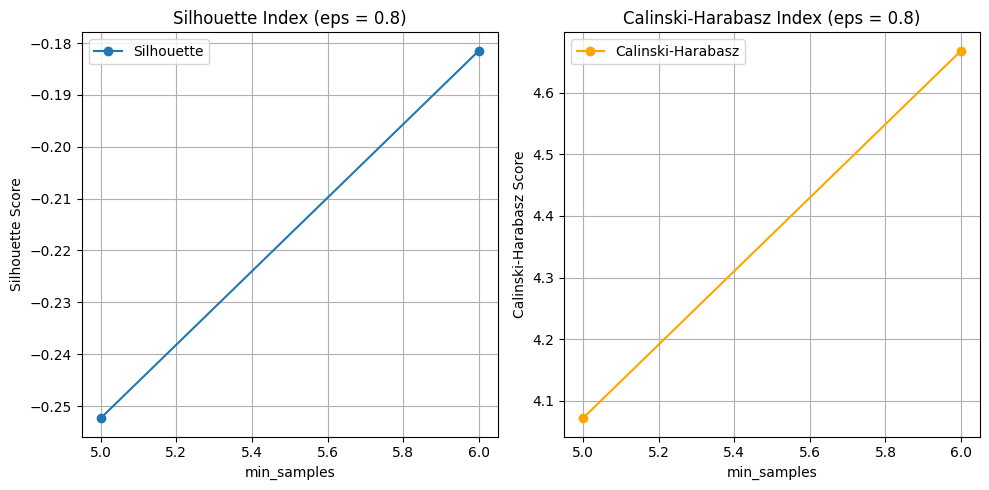

In [10]:
results_df_filtered["min_samples"] = results_df_filtered["min_samples"].astype(int)
results_df_filtered["eps"] = results_df_filtered["eps"].round(2)

filtered_db = results_df_filtered[(results_df_filtered["indice"] == "Silhouette") & (results_df_filtered["eps"] == 0.8)]
filtered_ch = results_df_filtered[(results_df_filtered["indice"] == "Calinski-Harabasz") & (results_df_filtered["eps"] == 0.8)]

plt.figure(figsize=(10, 5))

# Silhouette
plt.subplot(1, 2, 1)
plt.plot(filtered_db["min_samples"], filtered_db["valor"], marker="o", label="Silhouette")
plt.title("Silhouette Index (eps = 0.8)")
plt.xlabel("min_samples")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.legend()

# Calinski-Harabasz
plt.subplot(1, 2, 2)
plt.plot(filtered_ch["min_samples"], filtered_ch["valor"], marker="o", color="orange", label="Calinski-Harabasz")
plt.title("Calinski-Harabasz Index (eps = 0.8)")
plt.xlabel("min_samples")
plt.ylabel("Calinski-Harabasz Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Se puede observar que el mejor número para min_samples, con eps=0.8 es de 6, ya que es el que mejores resultados da para ambos índices.

DBSCAN con las métricas previamente selccionadas

In [22]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

db = DBSCAN(eps=0.8, min_samples=6).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Verificar etiquetas únicas
unique_labels = set(labels)

# Calcular índice de silueta si hay más de un clúster
if n_clusters_ > 1:
    silhouette_score = metrics.silhouette_score(X, labels)
    print("Silhouette Coefficient: %0.3f" % silhouette_score)
else:
    print("Silhouette Coefficient not defined for a single cluster.")


Estimated number of clusters: 7
Estimated number of noise points: 39648
Silhouette Coefficient: -0.181


Con los valores de eps y min_samples escogidos, se puede ver que el indice de silueta da un valor aceptable

## Tarea 4.3

Ahora se analizará como varía la calidad del cluster según se varíe el valor de eps y de min_samples.

In [13]:
import seaborn as sns

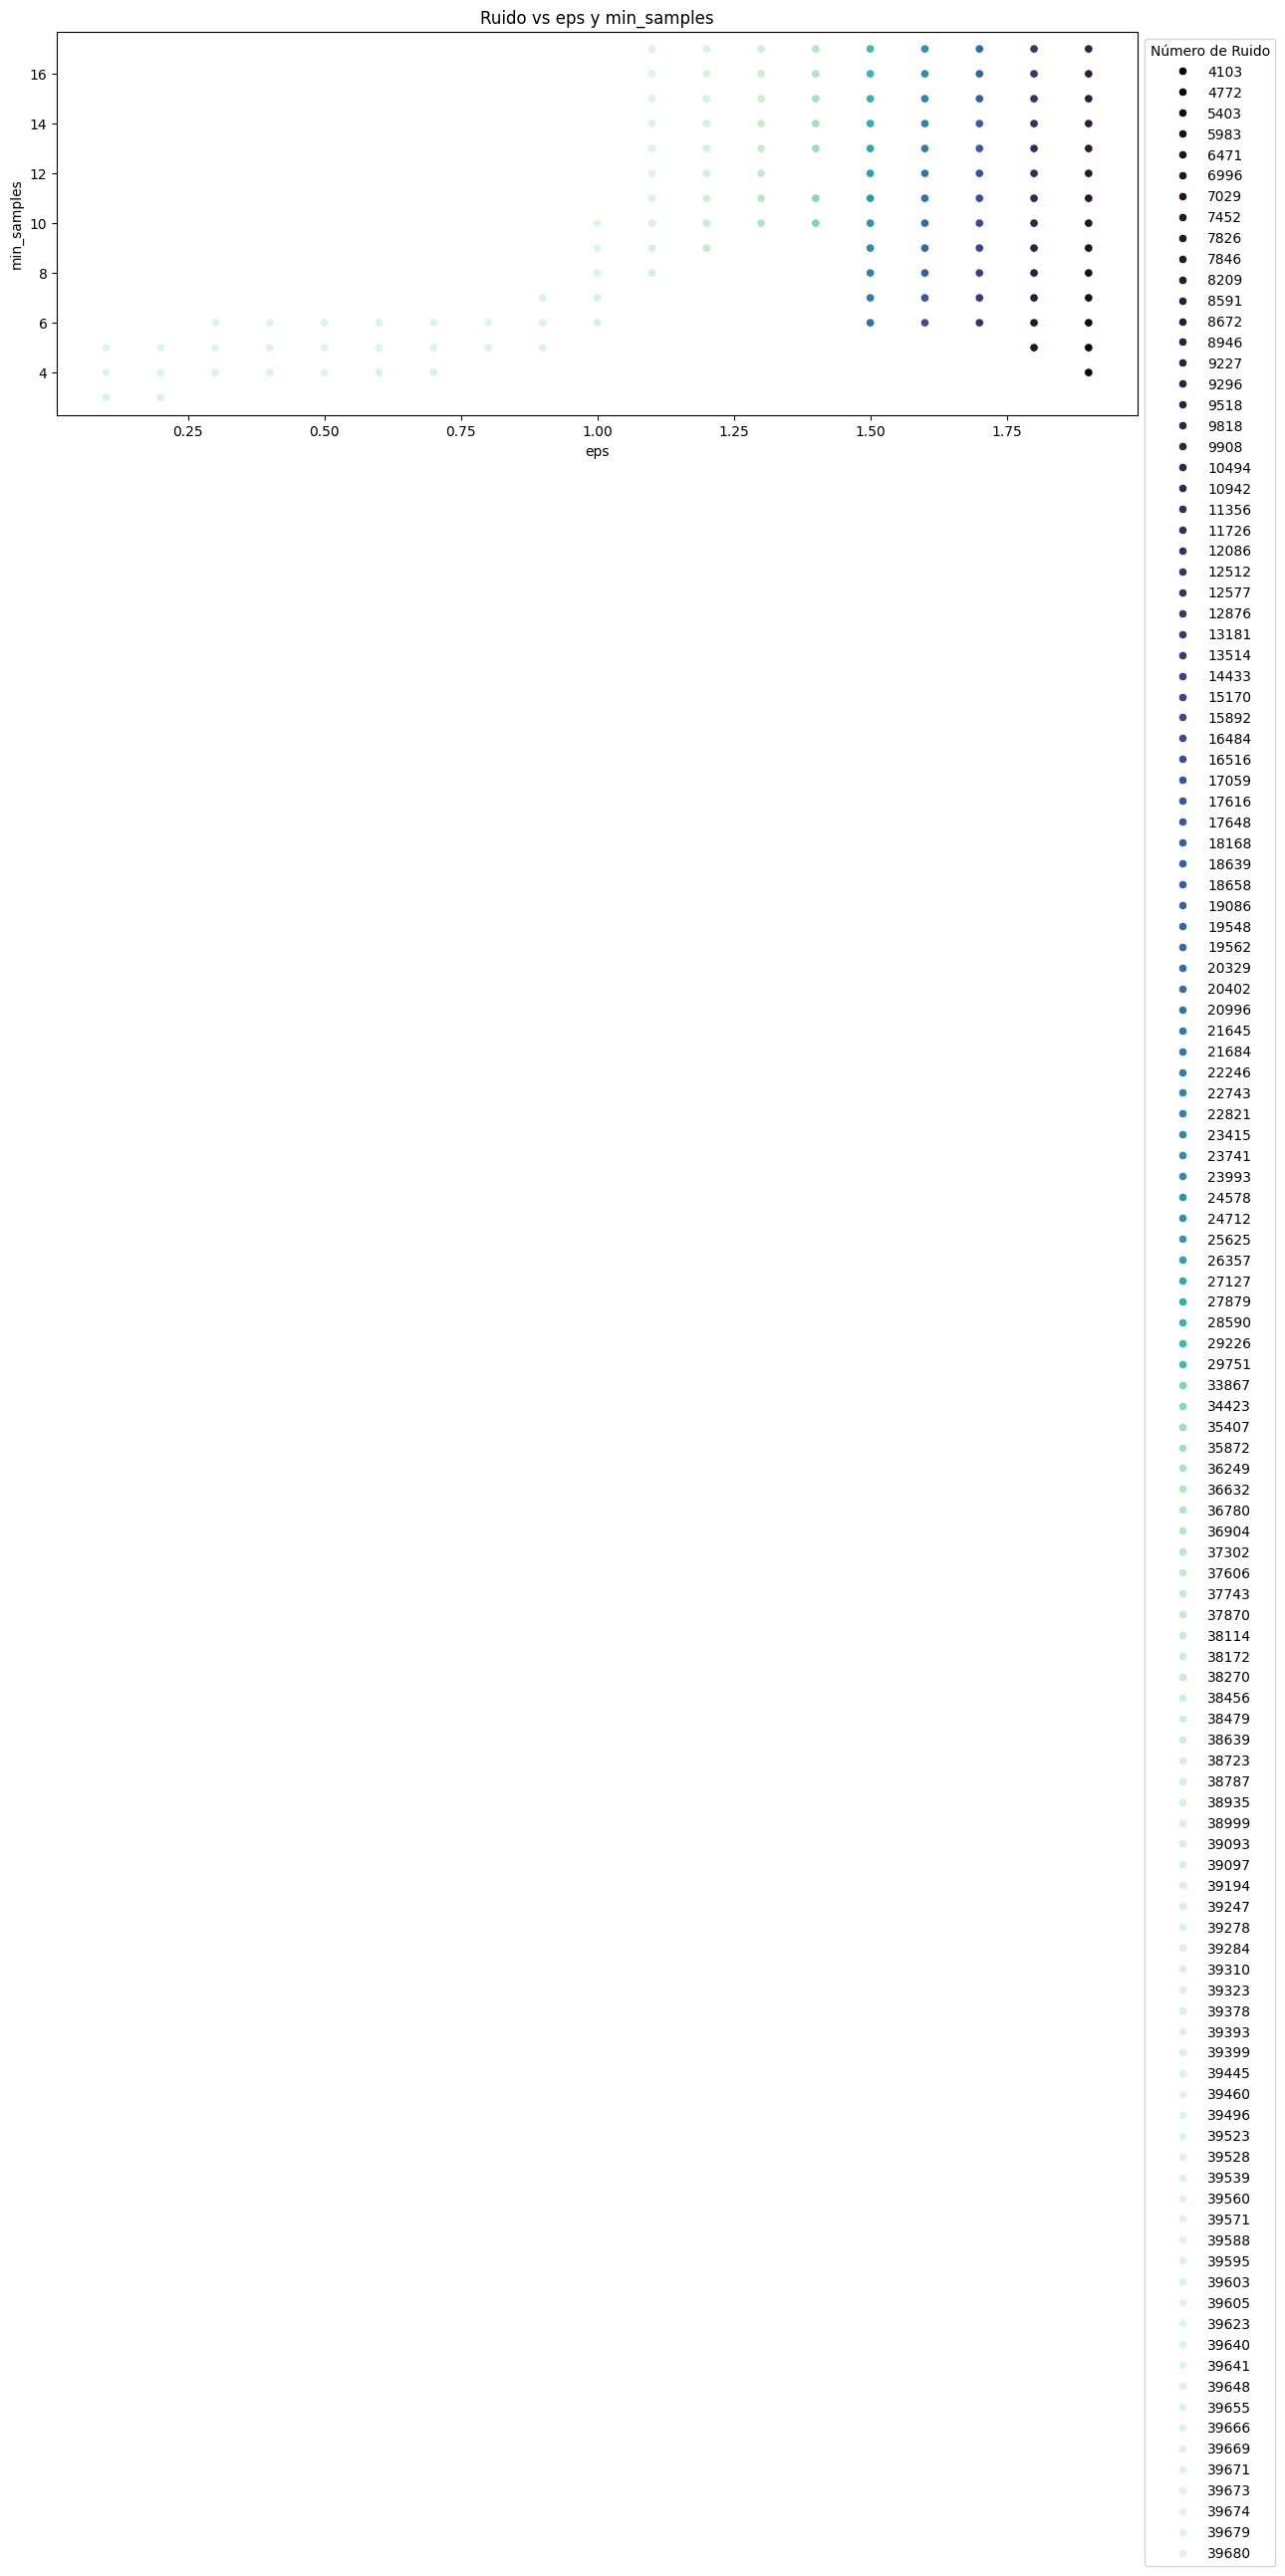

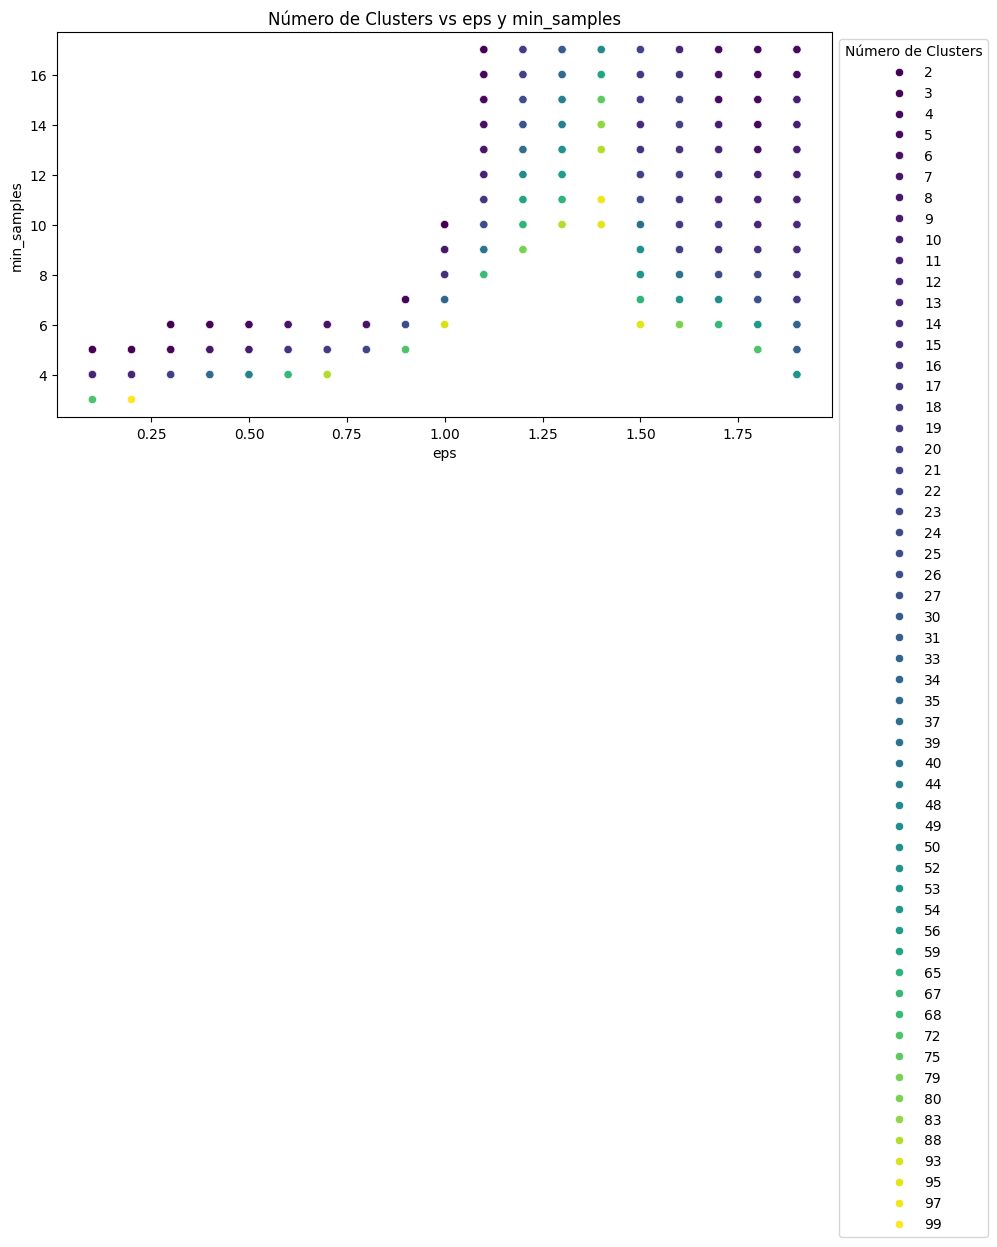

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

plt.figure(figsize=(14, 5))

noise_palette = sns.color_palette("mako", as_cmap=True)
scatter_noise = sns.scatterplot(
    data=results_df_filtered,
    x='eps',
    y='min_samples',
    hue='n_noise',
    palette=noise_palette,
    legend='full'
)

scatter_noise.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Número de Ruido")
plt.gca().collections[-1].colorbar = None

plt.title("Ruido vs eps y min_samples")
plt.xlabel("eps")
plt.ylabel("min_samples")

plt.show()

plt.figure(figsize=(10, 5))

cluster_palette = sns.color_palette("viridis", as_cmap=True)
scatter_clusters = sns.scatterplot(
    data=results_df_filtered,
    x='eps',
    y='min_samples',
    hue='n_clusters',
    palette=cluster_palette,
    legend='full'
)

scatter_clusters.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Número de Clusters")
plt.gca().collections[-1].colorbar = None 

plt.title("Número de Clusters vs eps y min_samples")
plt.xlabel("eps")
plt.ylabel("min_samples")

plt.show()


**Primera gráfica**: 
Se puede apreciar como a medida que se va aumentando el valor de eps el numero de puntos de ruido va disminuyendo. Esto ocurre debido a que el radio para considerar vecinos se expande, lo que permite que más puntos sean incluidos en clusters en lugar de ser clasificados como ruido. Sin embargo, solamente analizando esta gráfica no es posible determinar cuáles son los mejores valores de eps y min_samples ya que también depende del número de clusters.

**Segunda gráfica**:
Observando el gráfico se puede llegar a la conclusión de que valores razonables para eps y min_samples son aquellos que permitan una cantidad razonable de clusters pero sin demasiado ruido. Esos valores se pueden encontrar encontrar a la derecha del gráfico. Aproximádamente en 1.8 de eps y min_samples en 8.

## Tarea 4.4

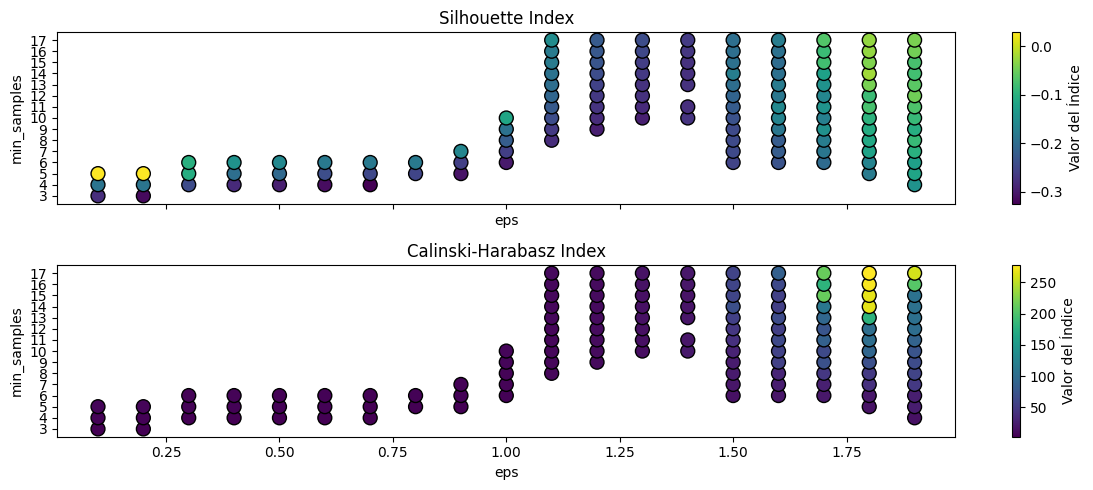

In [16]:
def plot_indices(results_df_filtered):
    indices = results_df_filtered['indice'].unique()
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, indice in enumerate(indices):
        subset = results_df_filtered[results_df_filtered['indice'] == indice]
        scatter = axes[i].scatter(
            subset['eps'], subset['min_samples'], c=subset['valor'], cmap='viridis', s=100, edgecolor='k'
        )
        axes[i].set_title(f"{indice} Index")
        axes[i].set_xlabel("eps")
        axes[i].set_ylabel("min_samples")
        axes[i].yaxis.set_major_locator(plt.MultipleLocator(1))
        fig.colorbar(scatter, ax=axes[i], label="Valor del Índice")

    for j in range(len(indices), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_indices(results_df_filtered)

Observando las gráficas de los valores de los índices, se puede apreciar que efectivamente los valores de eps y min_samples que mejor resultados dan son: eps=1.8 aprox y min_samples un poco más alto, en torno a 14 o 15.

## Tarea 4.5

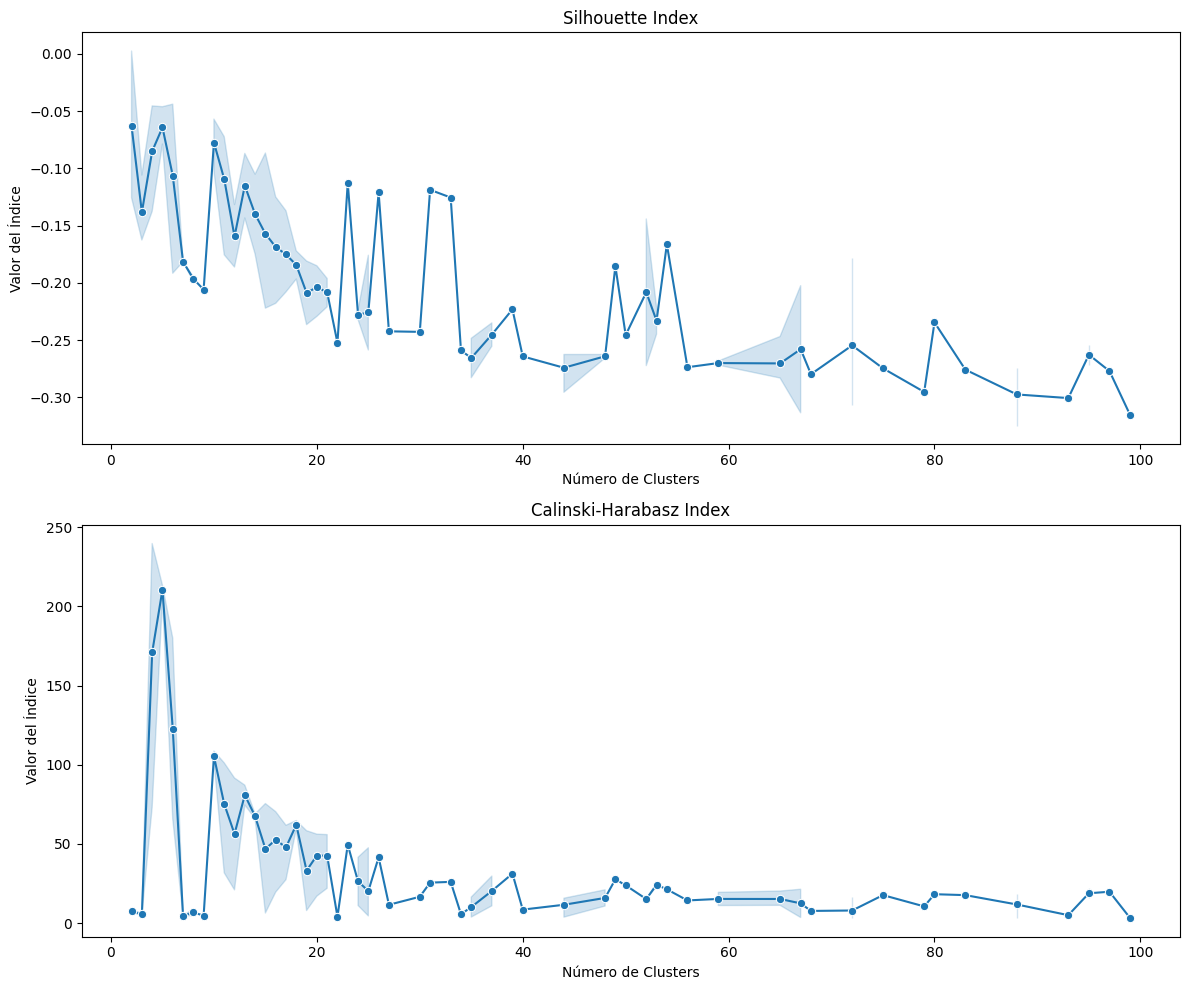

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

indices = ['Silhouette', 'Calinski-Harabasz']
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for i, indice in enumerate(indices):
    ax = axes[i]
    subset = results_df_filtered[(results_df_filtered['indice'] == indice)]
    sns.lineplot(data=subset, x='n_clusters', y='valor', ax=ax, marker='o')
    ax.set_title(f"{indice} Index")
    ax.set_xlabel("Número de Clusters")
    ax.set_ylabel("Valor del Índice")

plt.tight_layout()
plt.show()

Se puede ver como hay varias oscilaciones en los gráficos, proponiendo varios valores de clusters como correctos. Sin embargo, Podemos ver que hay un valor bastante alto en ambas gráficas para 12 clusters, lo cual encaja bastante bien para los valores de escogidos de eps y min_samples.
Por tanto, se determina que el número óptimo de clusters es 12.